In [1]:
from autograd import grad, hessian
import autograd.numpy as np
import autograd.scipy as sp
from scipy.stats import gaussian_kde
from scipy import misc
from scipy.stats import norm
from scipy.optimize import minimize

import math

#%matplotlib notebook # For interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:

class Model(object):
    def __init__(self, x_info, s_info, num_draws):
        self.x_info = x_info
        self.s_info = s_info
        self.s_draws = np.random.normal(loc=0, scale=1 / np.sqrt(s_info), size=num_draws)
        self.std_draws = np.random.normal(size=num_draws)
        self.x_draws = None
        self.x_dens = None
        
        self.log_joint_grad = grad(self.log_joint)
        self.log_joint_hess = hessian(self.log_joint)

    def mean_func(self, s, theta):
        #return theta * s + 0.3 # A linear model.
        #return (s + theta)**2 # A nonlinear choice
        #return np.sign(s + theta) * (s + theta)**2 + (s + theta) # A nonlinear choice
        return np.arctan(theta * s) # A nonlinear choice
        #return ((theta + 0.1)**2) * np.sign(s) * np.sqrt(np.abs(s)) # A nonlinear choice
        #return np.sin(s * np.exp(0.1 * theta)) # A nonlinear choice
        #return s + theta + 0.1 * (s - theta)**3 # A nonlinear choice
        
    def log_prob_x_given_s(self, x, s, theta):
        return -0.5 * self.x_info * (x - self.mean_func(s, theta))**2 + \
               0.5 * np.log(self.x_info) - 0.5 * np.log(2 * math.pi)
     
    def log_prob_s(self, s):
        return -0.5 * self.s_info * (s**2) + 0.5 * np.log(self.s_info) - 0.5 * np.log(2 * math.pi)
    
    def log_joint(self, s, x, theta):
        lik =  self.log_prob_x_given_s(x, s, theta) + self.log_prob_s(s)
        return lik
    
    def simulate_x(self, theta):
        self.x_draws = self.std_draws / np.sqrt(self.x_info) + model.mean_func(self.s_draws, theta)
        self.x_dens = gaussian_kde(self.x_draws)
        
    def log_prob(self, theta, x_obs):
        self.simulate_x(theta)
        return model.x_dens.logpdf(x_obs)
    
    def get_s_given_x_approx(self, theta, x_obs, s_mode_guess):
        s_opt_result = \
         minimize(lambda s: -1 * self.log_joint(s, x_obs, theta), s_mode_guess,
                  method='Nelder-Mead', options={'disp': False, 'maxiter': 1000})

        s_opt = s_opt_result.x[0]
        d = self.log_joint_hess(s_opt, x_obs, theta)

        if not s_opt_result.success:
            print 'Theta = %f, x_obs = %f' % (theta, x_obs)
            print s_opt_result

        assert s_opt_result.success
        assert d < 0

        return s_opt, 1 / (-d)

    def get_uros_log_prob(self, theta, x_obs, s_mode_guess=0.1):
        # Need to add back in a half log 2 pi to cancel the one from log_prob_s.
        s_opt, s_var = self.get_s_given_x_approx(theta, x_obs, s_mode_guess)
        return self.log_prob_x_given_s(x_obs, s_opt, theta) + \
               self.log_prob_s(s_opt) + \
               0.5 * np.log(s_var) + 0.5 * np.log(2 * math.pi)



        

In [3]:
# Sanity checks.

model = Model(x_info=100., s_info=5., num_draws=100000)

marginal_s_grid = np.linspace(-3 / np.sqrt(model.s_info), 3 / np.sqrt(model.s_info), 10000)
print np.sum(np.exp([ model.log_prob_s(s) for s in marginal_s_grid ])) * \
    (marginal_s_grid[1] - marginal_s_grid[0])

conditional_x_grid = np.linspace(-4 / np.sqrt(model.x_info), 4 / np.sqrt(model.x_info), 10000)
print np.sum(np.exp([ model.log_prob_x_given_s(x, 0.2, 0.1) for x in conditional_x_grid ])) * \
    (conditional_x_grid[1] - conditional_x_grid[0])
    



0.997302862514
0.999914452707


In [4]:
# Look directly at the marginals.

def get_log_s_given_x_grid(model, theta, x_obs, s_mode_guess=0.1, num_sd=4.0, grid_size=100):
    s_opt, s_var = model.get_s_given_x_approx(theta, x_obs, s_mode_guess)
    s_grid = np.linspace(s_opt - num_sd * np.sqrt(s_var), s_opt + num_sd * np.sqrt(s_var), grid_size)
    log_p_s_given_x = model.log_joint(s_grid, x_obs, theta)
    s_delta = s_grid[1] - s_grid[0]
    return s_grid, log_p_s_given_x - sp.misc.logsumexp(log_p_s_given_x) - np.log(s_delta), s_opt, s_var



def get_s_conditionals(model, theta, x_obs):
    model.simulate_x(theta)
    s_grid, log_p_s_given_x, s_opt, s_var = \
        get_log_s_given_x_grid(model, theta, x_obs, grid_size=100, num_sd=4)
    log_p_s_given_x_quadratic = [ -0.5 * ((s - s_opt)**2) / s_var - 0.5 * np.log(s_var) - \
                                  0.5 * np.log(2 * math.pi) for s in s_grid ]
    return s_grid, log_p_s_given_x, log_p_s_given_x_quadratic, s_opt, s_var

Total mass (should be close to one):
0.9999468903
1.0


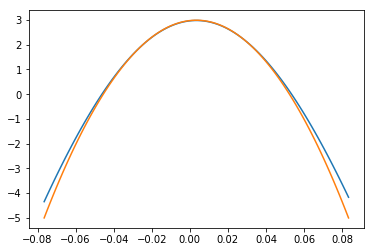

In [5]:
theta = 5.0
model.simulate_x(theta)
x_obs = np.median(model.x_draws)
s_grid, log_p_s_given_x, log_p_s_given_x_quadratic, s_opt, s_var = get_s_conditionals(model, theta, x_obs)

# When the x information is very high, this should be approximately quadratic, irrespective
# of the amount of s information.
delta_s = s_grid[1] - s_grid[0]

print 'Total mass (should be close to one):'
print np.sum(np.exp(log_p_s_given_x_quadratic) * delta_s)
print np.sum(np.exp(log_p_s_given_x) * delta_s)

plt.figure()
plt.plot(s_grid, log_p_s_given_x)
plt.plot(s_grid, log_p_s_given_x_quadratic)



Total mass (should be close to one):
0.993745752743
0.951987195793


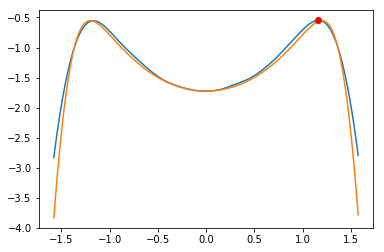

In [6]:
# Compare the marginal x density from simulation to eq. 4.6 in the paper. 

def get_x_log_density(model, theta, tail_eps=0.001, grid_size=100):
    model.simulate_x(theta)
    x_grid = np.linspace(np.percentile(model.x_draws, 100 * tail_eps),
                         np.percentile(model.x_draws, 100 * (1.0 - tail_eps)), grid_size)

    x_log_prob = model.x_dens.logpdf(x_grid)
    uros_x_log_prob = [ model.get_uros_log_prob(theta, x) for x in x_grid ]
    return x_grid, x_log_prob, uros_x_log_prob

theta = 5.0

# print sp.misc.logsumexp(uros_x_log_prob_nonnorm)
# print np.log(delta_x)
# uros_log_normalizer = sp.misc.logsumexp(uros_x_log_prob_nonnorm) + np.log(delta_x)
# uros_x_log_prob = uros_x_log_prob_nonnorm - uros_log_normalizer

x_grid, x_log_prob, uros_x_log_prob = get_x_log_density(model, theta)
delta_x = x_grid[1] - x_grid[0]

# Sanity check the density.  Should be close to one.
print 'Total mass (should be close to one):'
print np.sum(delta_x * np.exp(x_log_prob))
print np.sum(delta_x * np.exp(uros_x_log_prob))

# print 'Uros log normalizer (should be close to zero):'
# print uros_log_normalizer
plt.figure()
plt.plot(x_grid, x_log_prob)
plt.plot(x_grid, uros_x_log_prob)

x_max_ind = np.argmax(x_log_prob)
x_obs = x_grid[x_max_ind]
plt.plot(x_obs, x_log_prob[x_max_ind], 'ro')


x_obs = 0.617306
s_opt = -1.419375


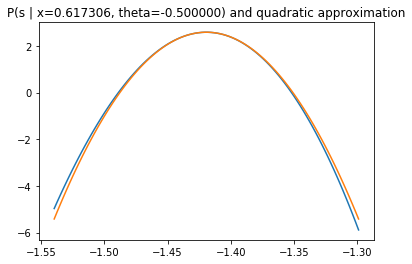

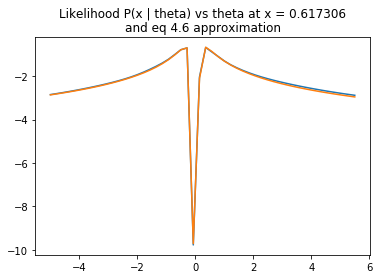

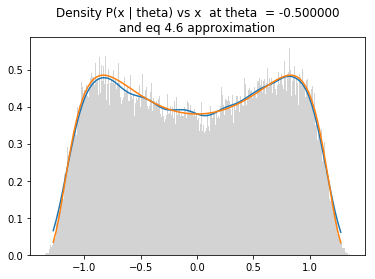

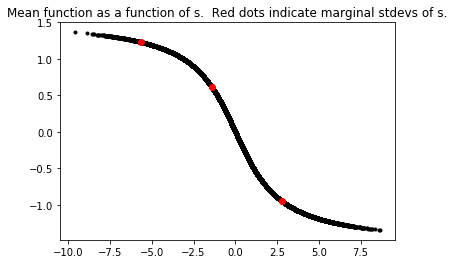

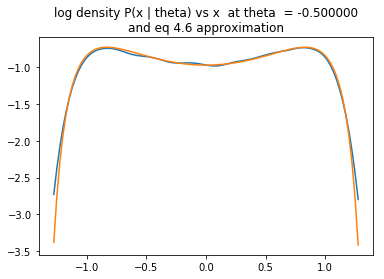

In [7]:
x_scale = 0.01
s_scale = 2.1
model = Model(x_info=1.0 / x_scale ** 2, s_info=1.0 / s_scale ** 2, num_draws=100000)

def get_x_log_pdf(theta, x_obs):
    model.simulate_x(theta)
    return model.x_dens.logpdf(x_obs)

theta_grid = np.linspace(-5., 5.5, 50)

#theta_base = np.median(theta_grid)
theta_base = -0.5
model.simulate_x(theta_base) 

x_obs = np.percentile(model.x_draws, 75.)
#x_obs = 60.
print 'x_obs = %f' % x_obs

uros_x_log_prob = [ model.get_uros_log_prob(theta, x_obs) for theta in theta_grid ]
x_log_prob = [ get_x_log_pdf(theta, x_obs) for theta in theta_grid ]

s_grid, log_p_s_given_x, log_p_s_given_x_quadratic, s_opt, s_var = \
    get_s_conditionals(model, theta_base, x_obs)
print 's_opt = %f' % s_opt

plt.figure()
plt.plot(s_grid, log_p_s_given_x)
plt.plot(s_grid, log_p_s_given_x_quadratic)
plt.title("P(s | x=%f, theta=%f) and quadratic approximation" % (x_obs, theta_base))

plt.figure()
plt.plot(theta_grid, x_log_prob)
plt.plot(theta_grid, uros_x_log_prob)
plt.title("Likelihood P(x | theta) vs theta at x = %f\nand eq 4.6 approximation" % x_obs)

#theta = 1.1
model.simulate_x(theta_base) 
x_grid, x_log_prob, uros_x_log_prob = get_x_log_density(model, theta_base)

plt.figure()
plt.plot(x_grid, np.exp(x_log_prob))
plt.plot(x_grid, np.exp(uros_x_log_prob))
n, bins, patches = plt.hist(model.x_draws, bins=500, normed=1, facecolor='lightgray')
plt.title("Density P(x | theta) vs x  at theta  = %f\nand eq 4.6 approximation" % theta_base)

# I hypothesize that if the mean function is not approximately quadratic
# between the two red dots (which indicate the high probability of the /marginal/ distribution
# of s), then eq. 4.6 will not be a good approximation.
plt.figure()
plt.plot(model.s_draws, model.mean_func(model.s_draws, theta_base), 'k.')
for num_sds in [-2.0, 0., 2.0]:
    s_offset = s_opt + num_sds / np.sqrt(model.s_info) 
    plt.plot(s_offset, model.mean_func(s_offset, theta_base), 'ro')
plt.title('Mean function as a function of s.  Red dots indicate marginal stdevs of s.')

plt.figure()
plt.plot(x_grid, x_log_prob)
plt.plot(x_grid, uros_x_log_prob)
plt.title("log density P(x | theta) vs x  at theta  = %f\nand eq 4.6 approximation" % theta_base)


In [8]:
# Perform EM if you're interested.

"""
model = Model(x_info=10., s_info=1., num_draws=1000)

x_obs = 10.
theta = 1 / (x_obs * model.s_info)
s = 0.1

print np.matrix(model.log_joint_hess(s, x_obs, theta))
std_draws = norm.ppf(np.arange(0.001, 0.999, 0.001))

def get_s_draws_given_x(theta, x_obs):
    s_opt, s_var = model.get_s_given_x_approx(theta, x_obs, s)
    s_draws = std_draws * np.sqrt(s_var) + s_opt
    return s_draws

    
def m_step(theta, s_draws, x_obs):
    theta_opt_result = \
        minimize(lambda theta: -1 * np.mean(model.log_prob_x_given_s(x_obs, s_draws, theta)),
                 theta,
                 method='Nelder-Mead')
    assert theta_opt_result.success
    return theta_opt_result.x[0]

theta_old = theta
diff = float('inf')

# You probably need more iters to actually converge.
max_iters = 100
iteration = 0
while diff > 1e-8 and iteration < max_iters:
    iteration += 1
    s_draws = get_s_draws_given_x(theta_old, x_obs)
    theta_new = m_step(theta_old, s_draws, x_obs)
    diff = np.abs(theta_new - theta_old)
    print 'Theta: %f   Diff: %f    Iter: %d' % (theta_new, diff, iteration)
    theta_old = theta_new

print 'Done:'
print('Maximizer: ', theta_new)
"""

"\nmodel = Model(x_info=10., s_info=1., num_draws=1000)\n\nx_obs = 10.\ntheta = 1 / (x_obs * model.s_info)\ns = 0.1\n\nprint np.matrix(model.log_joint_hess(s, x_obs, theta))\nstd_draws = norm.ppf(np.arange(0.001, 0.999, 0.001))\n\ndef get_s_draws_given_x(theta, x_obs):\n    s_opt, s_var = model.get_s_given_x_approx(theta, x_obs, s)\n    s_draws = std_draws * np.sqrt(s_var) + s_opt\n    return s_draws\n\n    \ndef m_step(theta, s_draws, x_obs):\n    theta_opt_result =         minimize(lambda theta: -1 * np.mean(model.log_prob_x_given_s(x_obs, s_draws, theta)),\n                 theta,\n                 method='Nelder-Mead')\n    assert theta_opt_result.success\n    return theta_opt_result.x[0]\n\ntheta_old = theta\ndiff = float('inf')\n\n# You probably need more iters to actually converge.\nmax_iters = 100\niteration = 0\nwhile diff > 1e-8 and iteration < max_iters:\n    iteration += 1\n    s_draws = get_s_draws_given_x(theta_old, x_obs)\n    theta_new = m_step(theta_old, s_draws, x_obs